In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import kmeans_pytorch
import random
import datetime as dt
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
articles = pd.read_csv("gs://ricstorage/articles.csv")
customers = pd.read_csv("gs://ricstorage/customers.csv")
transactions = pd.read_csv("gs://ricstorage/transactions_train.csv")

Transactions have customer_id and article_id, which are foreign keys for the customer and articles tables. Beside this, transaction also contains sales_channel_id.

In [3]:
# Perform the joins
merged_transactions = pd.merge(transactions, customers, on='customer_id', how='inner')

In [4]:
merged_transactions = pd.merge(merged_transactions, articles, on='article_id', how='inner')

In [5]:
#num_random_rows = 100000
#total_rows = len(merged_transactions)

# Generate a list of random indices without replacement
#random_indices = random.sample(range(total_rows), num_random_rows)

# Use the random indices to select the random rows from the DataFrame
#merged_transactions = merged_transactions.iloc[random_indices]

In [6]:
row_count = merged_transactions.shape[0]
print("Count of rows in random_sample:", row_count)

Count of rows in random_sample: 31788324


In [7]:
merged_transactions = merged_transactions.drop('FN',axis=1)
merged_transactions = merged_transactions.drop('postal_code',axis=1)

Transactions have customer_id and article_id, which are foreign keys for the customer and articles tables. Beside this, transaction also contains sales_channel_id.

In [8]:
merged_transactions['t_dat'] = pd.to_datetime(merged_transactions['t_dat'])

In [9]:
merged_transactions['year_month'] = merged_transactions['t_dat'].dt.to_period('M')
merged_transactions['year'] = merged_transactions['t_dat'].dt.year
merged_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,Active,club_member_status,fashion_news_frequency,age,product_code,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,year_month,year
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,NaN,ACTIVE,NONE,24.0,663713,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa...",2018-09,2018
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,NaN,ACTIVE,NONE,24.0,663713,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa...",2018-09,2018
2,2018-11-05,1385e5f3a2d3dbd21237f91faf81254a6d96de31b07b0b...,663713001,0.050831,2,NaN,ACTIVE,NONE,25.0,663713,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa...",2018-11,2018
3,2018-11-05,1385e5f3a2d3dbd21237f91faf81254a6d96de31b07b0b...,663713001,0.050831,2,NaN,ACTIVE,NONE,25.0,663713,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa...",2018-11,2018
4,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,2,1.0,ACTIVE,Regularly,30.0,663713,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa...",2018-09,2018


In [10]:
# Filter the DataFrame to extract data from '2020-08-01' onwards
data_2020 = merged_transactions[merged_transactions['t_dat'] >= '2020-08-26']
#data_2020 = merged_transactions[merged_transactions['t_dat'] >= '2020-08-01']

In [11]:
data_2020.count()

t_dat                           1043390
customer_id                     1043390
article_id                      1043390
price                           1043390
sales_channel_id                1043390
Active                           455962
club_member_status              1041690
fashion_news_frequency          1041054
age                             1039499
product_code                    1043390
prod_name                       1043390
product_type_no                 1043390
product_type_name               1043390
product_group_name              1043390
graphical_appearance_no         1043390
graphical_appearance_name       1043390
colour_group_code               1043390
colour_group_name               1043390
perceived_colour_value_id       1043390
perceived_colour_value_name     1043390
perceived_colour_master_id      1043390
perceived_colour_master_name    1043390
department_no                   1043390
department_name                 1043390
index_code                      1043390


In [12]:
#merged_transactions = 1

In [13]:
df = data_2020.groupby(["year_month", "sales_channel_id"])["article_id"].count().reset_index()

In [14]:
# Assuming 'year_month' is a Period column in your DataFrame
df['year_month'] = df['year_month'].dt.strftime('%Y-%m')

In [15]:
unique_month = data_2020['year_month'].unique()
print(unique_month)

<PeriodArray>
['2020-09', '2020-08']
Length: 2, dtype: period[M]


In [16]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [17]:
missing_data(data_2020)

,Total,Percent
Active,587428,56.299945
age,3891,0.372919
fashion_news_frequency,2336,0.223886
club_member_status,1700,0.162930
detail_desc,348,0.033353
t_dat,0,0.000000
index_group_name,0,0.000000
department_no,0,0.000000
department_name,0,0.000000
index_code,0,0.000000


In [18]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return tt

In [19]:
unique_values(data_2020)

,Total,Uniques
t_dat,1043390,28
customer_id,1043390,233174
article_id,1043390,28297
price,1043390,4569
sales_channel_id,1043390,2
Active,455962,1
club_member_status,1041690,3
fashion_news_frequency,1041054,3
age,1039499,81
product_code,1043390,14743


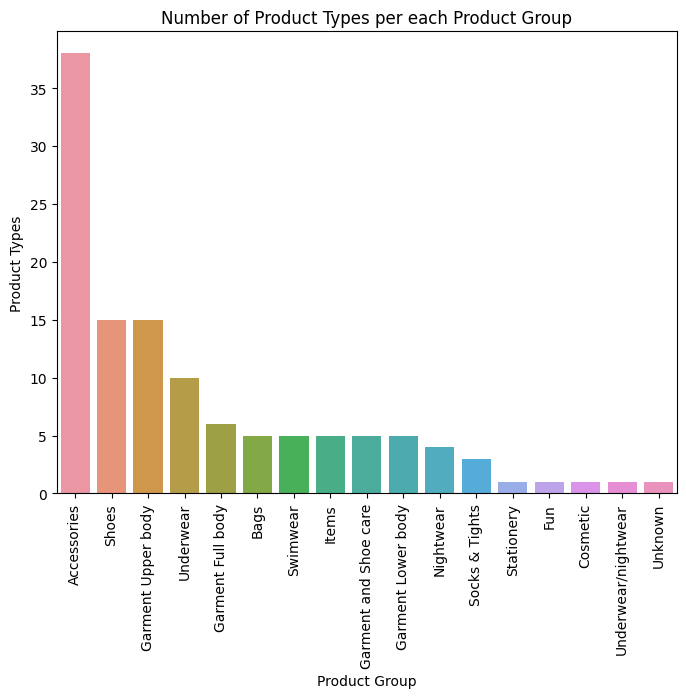

In [20]:
temp = data_2020.groupby(["product_group_name"])["product_type_name"].nunique()
df = pd.DataFrame({'Product Group': temp.index,
                   'Product Types': temp.values
                  })
df = df.sort_values(['Product Types'], ascending=False)
plt.figure(figsize = (8,6))
plt.title('Number of Product Types per each Product Group')
s = sns.barplot(x = 'Product Group', y="Product Types", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

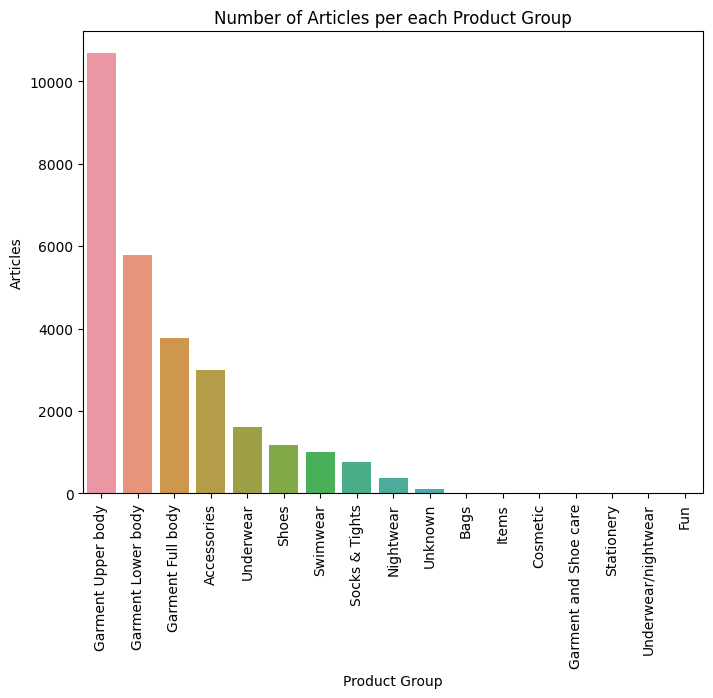

In [21]:
temp = data_2020.groupby(["product_group_name"])["article_id"].nunique()
df = pd.DataFrame({'Product Group': temp.index,
                   'Articles': temp.values
                  })
df = df.sort_values(['Articles'], ascending=False)
plt.figure(figsize = (8,6))
plt.title('Number of Articles per each Product Group')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Product Group', y="Articles", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

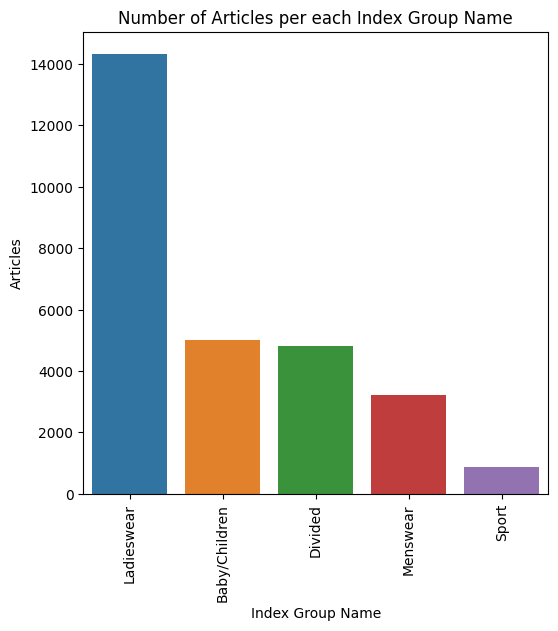

In [22]:
temp = data_2020.groupby(["index_group_name"])["article_id"].nunique()
df = pd.DataFrame({'Index Group Name': temp.index,
                   'Articles': temp.values
                  })
df = df.sort_values(['Articles'], ascending=False)
plt.figure(figsize = (6,6))
plt.title(f'Number of Articles per each Index Group Name')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Index Group Name', y="Articles", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

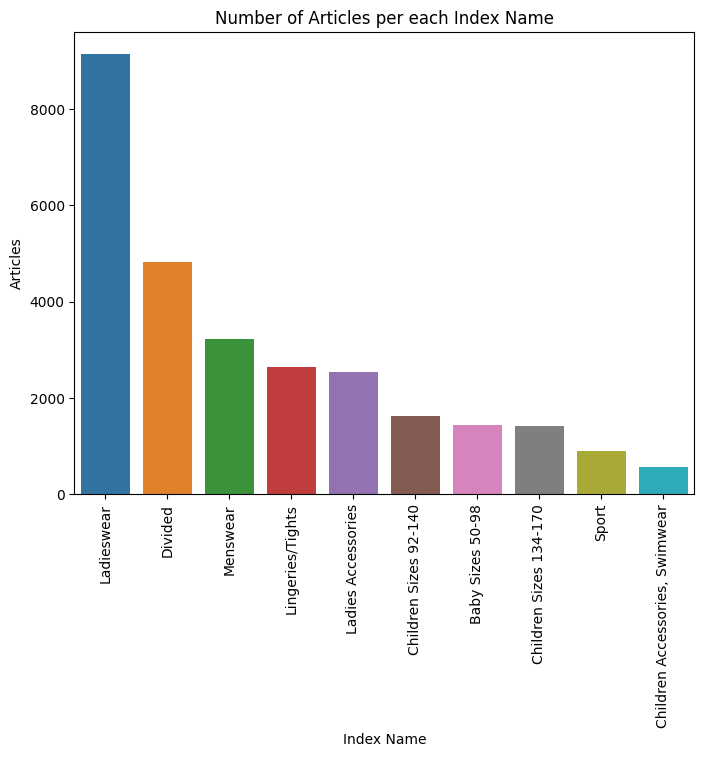

In [23]:
temp = data_2020.groupby(["index_name"])["article_id"].nunique()
df = pd.DataFrame({'Index Name': temp.index,
                   'Articles': temp.values
                  })
df = df.sort_values(['Articles'], ascending=False)
plt.figure(figsize = (8,6))
plt.title(f'Number of Articles per each Index Name')
s = sns.barplot(x = 'Index Name', y="Articles", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

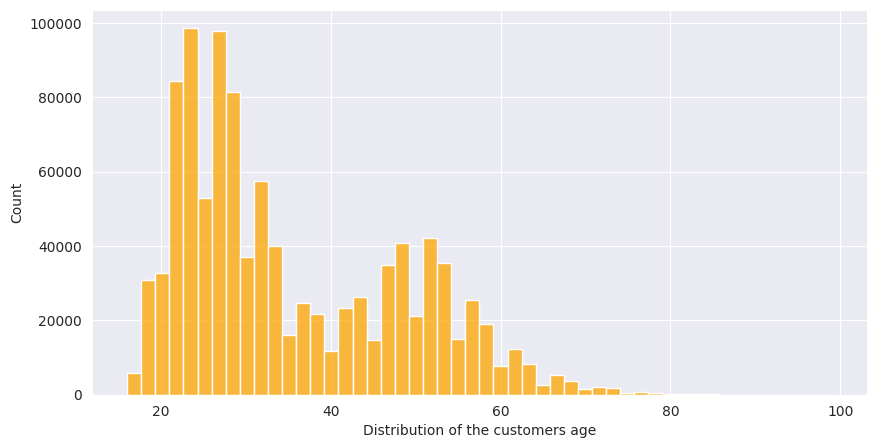

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=data_2020, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

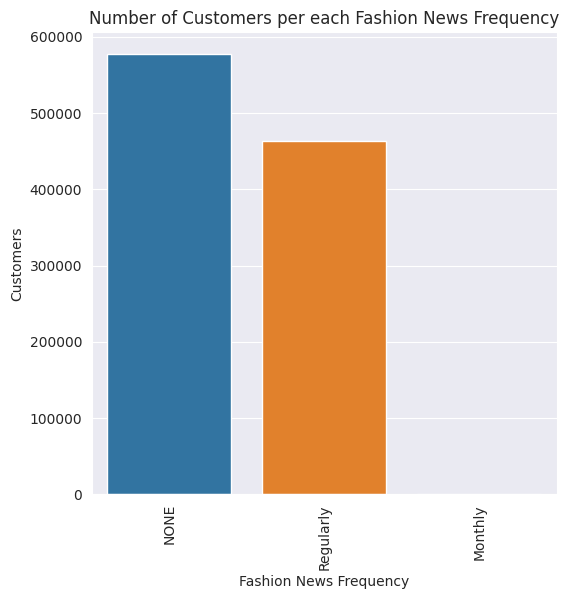

In [25]:
temp = data_2020.groupby(["fashion_news_frequency"])["customer_id"].count()
df = pd.DataFrame({'Fashion News Frequency': temp.index,
                   'Customers': temp.values
                  })
df = df.sort_values(['Customers'], ascending=False)
plt.figure(figsize = (6,6))
plt.title(f'Number of Customers per each Fashion News Frequency')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Fashion News Frequency', y="Customers", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

In [26]:
data_2020['club_member_status'].unique()

array(['ACTIVE', 'PRE-CREATE', nan, 'LEFT CLUB'], dtype=object)

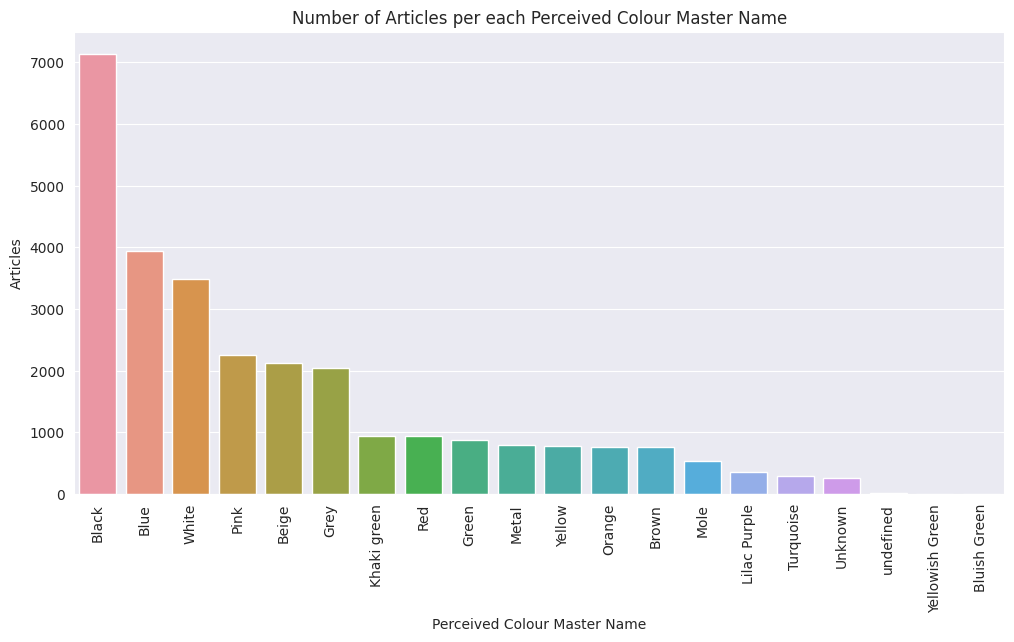

In [27]:
temp = data_2020.groupby(["perceived_colour_master_name"])["article_id"].nunique()
df = pd.DataFrame({'Perceived Colour Master Name': temp.index,
                   'Articles': temp.values
                  })
df = df.sort_values(['Articles'], ascending=False)
plt.figure(figsize = (12,6))
plt.title(f'Number of Articles per each Perceived Colour Master Name')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Perceived Colour Master Name', y="Articles", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

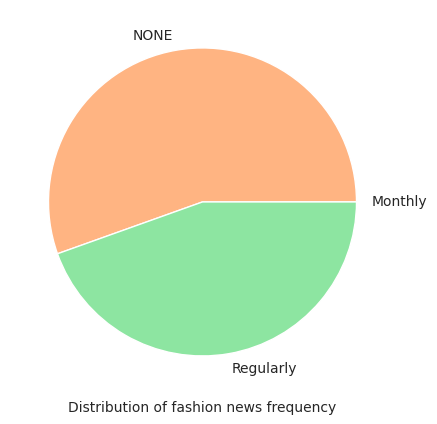

In [28]:
pie_data = data_2020[['customer_id', 'fashion_news_frequency']].groupby('fashion_news_frequency').count()
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
# ax = sns.histplot(data=customers, x='fashion_news_frequency', color='orange')
# ax = sns.pie(data=customers, x='fashion_news_frequency', color='orange')
colors = sns.color_palette('pastel')
ax.pie(pie_data.customer_id, labels=pie_data.index, colors = colors)
ax.set_facecolor('lightgrey')
ax.set_xlabel('Distribution of fashion news frequency')
plt.show()

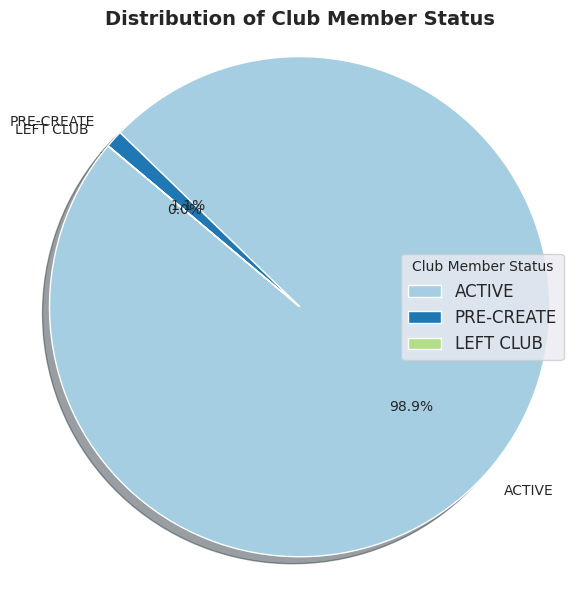

In [29]:
import matplotlib.pyplot as plt

# Group by club_member_status and count the number of customers in each status
temp = data_2020['club_member_status'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))  # Set a smaller figure size
plt.pie(
    temp,
    labels=temp.index,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True,
    colors=plt.cm.Paired(range(len(temp)))
)

# Add title and legend
plt.title('Distribution of Club Member Status', fontsize=14, fontweight='bold')  # Reduce title font size
plt.legend(temp.index, title='Club Member Status', loc='best', fontsize=12)  # Reduce legend font size

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Center the pie chart within the figure
plt.tight_layout()

# Show the pie chart
plt.show()


In [30]:
df = data_2020.groupby(["year_month", "sales_channel_id"])["article_id"].count().reset_index()

In [31]:
# Assuming 'year_month' is a Period column in your DataFrame
df['year_month'] = df['year_month'].dt.strftime('%Y-%m')

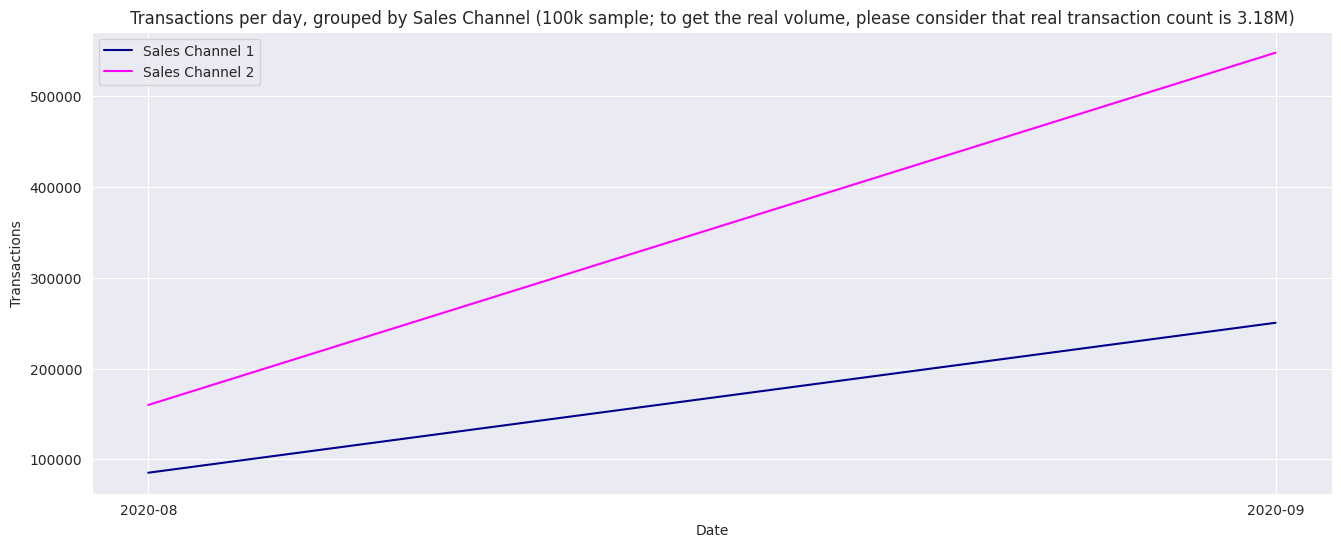

In [32]:
df.columns = ["year_month", "Sales Channel Id", "Transactions"]
fig, ax = plt.subplots(1, 1, figsize=(16,6))
g1 = ax.plot(df.loc[df["Sales Channel Id"]==1, "year_month"], df.loc[df["Sales Channel Id"]==1, "Transactions"], label="Sales Channel 1", color="Darkblue")
g2 = ax.plot(df.loc[df["Sales Channel Id"]==2, "year_month"], df.loc[df["Sales Channel Id"]==2, "Transactions"], label="Sales Channel 2", color="Magenta")
plt.xlabel("Date")
plt.ylabel("Transactions")
ax.legend()
plt.title(f"Transactions per day, grouped by Sales Channel (100k sample; to get the real volume, please consider that real transaction count is {round(merged_transactions.shape[0]/10.e6,2)}M)")
plt.show()

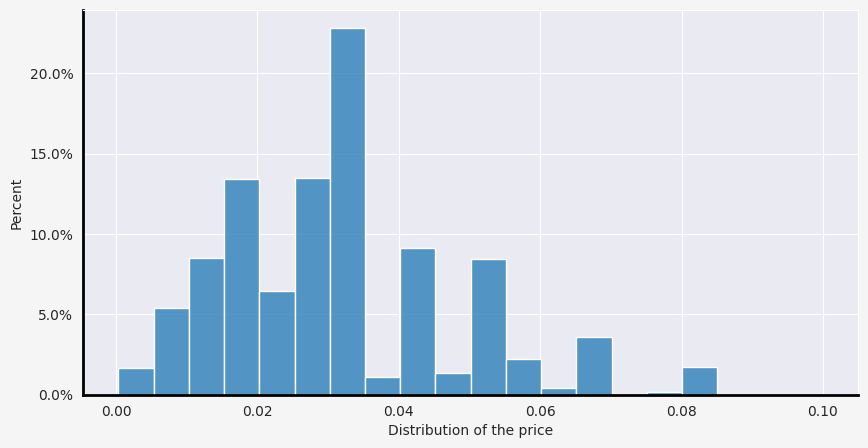

In [33]:
fig, ax = plt.subplots(figsize=(10,5), facecolor='#f6f5f5')
data = data_2020[data_2020['price']<0.1]
ax = sns.histplot(data=data, x='price', bins=20, stat="percent")
ax.set_xlabel('Distribution of the price')
for loc in ['bottom', 'left']:
    ax.spines[loc].set_visible(True)
    ax.spines[loc].set_linewidth(2)
    ax.spines[loc].set_color('black')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

# creating a atomic file

In [34]:
df = data_2020[["t_dat","year_month","customer_id","article_id","price","sales_channel_id"]]

This conversion is often useful when working with time series data or when you need to compare and analyze timestamps across different datasets or systems.

In [35]:
last_ts = df['t_dat'].max()

In [36]:
# Use tqdm.pandas() to enable progress_apply on a pandas DataFrame
tqdm.pandas()

# Now you can use progress_apply
df['ldbw'] = df['t_dat'].progress_apply(lambda d: last_ts - (last_ts - d).floor('7D'))

100%|██████████| 1043390/1043390 [01:58<00:00, 8815.40it/s]
/var/tmp/ipykernel_5947/3275170337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ldbw'] = df['t_dat'].progress_apply(lambda d: last_ts - (last_ts - d).floor('7D'))


In [37]:
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

In [38]:
print(df.columns)

Index(['t_dat', 'year_month', 'customer_id', 'article_id', 'price',
       'sales_channel_id', 'ldbw'],
      dtype='object')


In [39]:
df = df.join(weekly_sales, on=['ldbw', 'article_id'],rsuffix='_df')

In [40]:
print(df.columns)

Index(['t_dat', 'year_month', 'customer_id', 'article_id', 'price',
       'sales_channel_id', 'ldbw', 'count', 'year_month_df', 'price_df',
       'sales_channel_id_df'],
      dtype='object')


In [41]:
weekly_sales = weekly_sales.reset_index().set_index('article_id')
last_day = last_ts.strftime('%Y-%m-%d')

In [42]:
join_df = df.join(
    weekly_sales.loc[weekly_sales['ldbw']==last_day, ['count']],
    on='article_id', rsuffix="_targ")

In [43]:
print(join_df.columns)

Index(['t_dat', 'year_month', 'customer_id', 'article_id', 'price',
       'sales_channel_id', 'ldbw', 'count', 'year_month_df', 'price_df',
       'sales_channel_id_df', 'count_targ'],
      dtype='object')


In [44]:
join_df['count_targ'].fillna(0, inplace=True)

In [45]:
del weekly_sales

In [46]:
#Calculate sales rate adjusted for changes in product popularity
join_df['quotient'] = join_df['count_targ'] / join_df['count']

In [47]:
#Take supposedly popular products¶
N=100
target_sales = join_df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
general_pred = target_sales.nlargest(N).index.tolist()

In [48]:
purchase_dict = {}

In [49]:
purchase_dict = {}

for i in tqdm(df.index):
    cust_id = join_df.at[i, 'customer_id']
    art_id = join_df.at[i, 'article_id']
    t_dat = join_df.at[i, 't_dat']

    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}

    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    x = max(1, (last_ts - t_dat).days)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    y = a / np.sqrt(x) + b * np.exp(-c*x) - d

    value = join_df.at[i, 'quotient'] * max(0, y)
    purchase_dict[cust_id][art_id] += value

100%|██████████| 1043390/1043390 [00:50<00:00, 20804.62it/s]


In [50]:
# Reshape the nested dictionary into a flat structure
flat_purchase_dict = {'customer_id': [], 'article_id': [], 'purchase_value': []}

for cust_id, articles in purchase_dict.items():
    for art_id, purchase_value in articles.items():
        flat_purchase_dict['customer_id'].append(cust_id)
        flat_purchase_dict['article_id'].append(art_id)
        flat_purchase_dict['purchase_value'].append(purchase_value)

# Convert the flat dictionary to a DataFrame
purchase_df = pd.DataFrame(flat_purchase_dict)

In [51]:
# Assuming 'customer_id' and 'article_id' are the common columns
purchase_df = pd.merge(purchase_df, join_df[['customer_id', 'article_id', 't_dat']], on=['customer_id', 'article_id'], how='left')

In [52]:
purchase_df.head()

,customer_id,article_id,purchase_value,t_dat
0,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,723529001,95755.502144,2020-09-19
1,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,822959001,95755.502144,2020-09-19
2,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,741356002,95755.502144,2020-09-19
3,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,599580038,95755.502144,2020-09-19
4,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,687034023,95755.502144,2020-09-19


In [53]:
purchase_df['timestamp'] = purchase_df.t_dat.values.astype(np.int64) // 10 ** 9
purchase_df.head()

,customer_id,article_id,purchase_value,t_dat,timestamp
0,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,723529001,95755.502144,2020-09-19,1600473600
1,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,822959001,95755.502144,2020-09-19,1600473600
2,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,741356002,95755.502144,2020-09-19,1600473600
3,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,599580038,95755.502144,2020-09-19,1600473600
4,a2379ca38a6b9ac53d9217b664d6ca51c140e88381ef91...,687034023,95755.502144,2020-09-19,1600473600


In [54]:
temp = purchase_df[['customer_id', 'article_id', 'timestamp']].rename(
    columns={'customer_id': 'user_id:token', 'article_id': 'item_id:token', 'timestamp': 'timestamp:float'})
temp.count()

user_id:token      1043390
item_id:token      1043390
timestamp:float    1043390
dtype: int64

In [55]:
# Assuming 'df' is your DataFrame
null_columns = temp.columns[temp.isnull().any()]

# To get the count of missing values in each column
missing_values_count = temp[null_columns].isnull().sum()

# To print the column names with missing values and their respective missing value counts
print("Columns with missing values:")
for col in null_columns:
    print(f"{col}: {missing_values_count[col]} missing values")

Columns with missing values:


In [56]:
temp.to_csv('recbole_data/recbox_data/recbox_data.inter', index=False, sep='\t')

In [57]:
import logging
from logging import getLogger
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.sequential_recommender import GRU4Rec
from recbole.model.sequential_recommender import BERT4Rec
from recbole.trainer import Trainer
from recbole.utils import init_seed, init_logger

2023-12-10 18:03:37.725283: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 18:03:38.977343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [58]:
parameter_dict = {
    #'data_path': "gs://ricstorage/recbox_data",
    'data_path': "recbole_data/",
    'USER_ID_FIELD': 'user_id',
    'ITEM_ID_FIELD': 'item_id',
    'TIME_FIELD': 'timestamp',
    'user_inter_num_interval': "[10,inf)",
    'item_inter_num_interval': "[20,inf)",
    'load_col': {'inter': ['user_id', 'item_id', 'timestamp']},
    'train_neg_sample_args' : None,
    'loss_type': 'CE',
    'neg_sampling': None,
    'epochs':5,
    'eval_args': {
        'split': {'RS': [7, 0, 3]},
        'group_by': 'user',
        'order': 'TO',
        'mode': 'full',
        'metric_decimal_place': 4,
        'metrics': ['Recall', 'MRR', 'MAP','Precision','Hit'],
        'topk': 12
    }
}

config = Config(model='GRU4Rec', dataset='recbox_data', config_dict=parameter_dict) #,

# init random seed
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()
# Create handlers
c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)
logger.addHandler(c_handler)

# write config info into log
logger.info(config)

10 Dec 18:03    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = recbole_data/recbox_data
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 5
train_batch_size = 2048
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}, 'metric_decimal_place': 4, 'metrics': ['Recall', 'MRR', 'MAP', 'Precision', 'Hit'], 'topk': 12}
repeatable = True
metrics = ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = MRR@10
va

In [59]:
config


General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = recbole_data/recbox_data
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 5
train_batch_size = 2048
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}, 'metric_decimal_place': 4, 'metrics': ['Recall', 'MRR', 'MAP', 'Precision', 'Hit'], 'topk': 12}
repeatable = True
metrics = ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = MRR@10
valid_metric_bigger = Tr

In [60]:
dataset = create_dataset(config)
logger.info(dataset)

10 Dec 18:03    INFO  recbox_data
The number of users: 11664
Average actions of users: 14.712681128354626
The number of items: 2387
Average actions of items: 71.91701592623637
The number of inters: 171594
The sparsity of the dataset: 99.38368580841698%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 11664
Average actions of users: 14.712681128354626
The number of items: 2387
Average actions of items: 71.91701592623637
The number of inters: 171594
The sparsity of the dataset: 99.38368580841698%
Remain Fields: ['user_id', 'item_id', 'timestamp']


In [61]:
# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)

10 Dec 18:03    INFO  [Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
10 Dec 18:03    INFO  [Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}, 'metric_decimal_place': 4, 'metrics': ['Recall', 'MRR', 'MAP', 'Precision', 'Hit'], 'topk': 12}]
[Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}, 'metric_decimal_place': 4, 'metrics': ['Recall', 'MRR', 'MAP', 'Precision', 'Hit'], 'topk': 12}]


In [62]:
# model loading and initialization
model = GRU4Rec(config, train_data.dataset).to(config['device'])
logger.info(model)

10 Dec 18:03    INFO  GRU4Rec(
  (item_embedding): Embedding(2387, 64, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(64, 128, bias=False, batch_first=True)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (loss_fct): CrossEntropyLoss()
)
Trainable parameters: 234752
GRU4Rec(
  (item_embedding): Embedding(2387, 64, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(64, 128, bias=False, batch_first=True)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (loss_fct): CrossEntropyLoss()
)
Trainable parameters: 234752


In [63]:
# trainer loading and initialization
trainer = Trainer(config, model)

In [64]:
# model training
best_valid_score, best_valid_result = trainer.fit(train_data)

10 Dec 18:04    INFO  epoch 0 training [time: 41.80s, train loss: 439.9429]
epoch 0 training [time: 41.80s, train loss: 439.9429]
10 Dec 18:04    INFO  Saving current: saved/GRU4Rec-Dec-10-2023_18-03-53.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-03-53.pth
10 Dec 18:05    INFO  epoch 1 training [time: 39.60s, train loss: 423.0378]
epoch 1 training [time: 39.60s, train loss: 423.0378]
10 Dec 18:05    INFO  Saving current: saved/GRU4Rec-Dec-10-2023_18-03-53.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-03-53.pth
10 Dec 18:05    INFO  epoch 2 training [time: 38.45s, train loss: 417.3609]
epoch 2 training [time: 38.45s, train loss: 417.3609]
10 Dec 18:05    INFO  Saving current: saved/GRU4Rec-Dec-10-2023_18-03-53.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-03-53.pth
10 Dec 18:06    INFO  epoch 3 training [time: 39.57s, train loss: 407.7511]
epoch 3 training [time: 39.57s, train loss: 407.7511]
10 Dec 18:06    INFO  Saving current: saved/GRU4Rec-Dec-10-2023_18-03-53.pth
Saving 

In [65]:
from recbole.utils.case_study import full_sort_topk
external_user_ids = dataset.id2token(
    dataset.uid_field, list(range(dataset.user_num)))[1:]#fist element in array is 'PAD'(default of Recbole) ->remove it 

In [66]:
topk_items = []
for internal_user_id in list(range(dataset.user_num))[1:]:
    _, topk_iid_list = full_sort_topk([internal_user_id], model, test_data, k=12, device=config['device'])
    last_topk_iid_list = topk_iid_list[-1]
    external_item_list = dataset.id2token(dataset.iid_field, last_topk_iid_list.cpu()).tolist()
    topk_items.append(external_item_list)
print(len(topk_items))

11663


In [67]:
# Determine the total number of items in your dataset
total_items = len(dataset)
print(total_items)

159931


In [68]:
external_item_str = [' '.join(x) for x in topk_items]
result = pd.DataFrame(external_user_ids, columns=['customer_id'])
result['prediction'] = external_item_str
result.head()

,customer_id,prediction
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,900267001 765743007 706016002 900279001 905957...
1,9d5b2ad4d39a93106a9995b6d20292c168e178c133ca45...,905957001 933989001 867969003 885951001 863595...
2,03c3771e117f921c472552497e243607243fd7de0c57fd...,905957007 923037001 900267001 900279001 867969...
3,7b07c1844804a1b435f3a613560bb1c0132c63455a9b89...,863583002 923758001 905957001 914441004 863595...
4,e266bff45e8d2418205e8bd42b64bdd4a03c7b1ef72b72...,751471043 924243001 898713001 898694001 850917...


In [69]:
test_data.dataset

recbox_data
The number of users: 11664
Average actions of users: 3.666809568721598
The number of items: 2387
Average actions of items: 18.206045125585355
The number of inters: 42766
The sparsity of the dataset: 99.84639735237107%
Remain Fields: ['user_id', 'item_id', 'timestamp', 'item_id_list', 'timestamp_list', 'item_length']

In [70]:
test_data.dataset['item_id_list'].shape

torch.Size([42766, 50])

In [71]:
len(test_data.dataset['item_id'])

42766

In [72]:
test_data.dataset['user_id'].shape

torch.Size([42766])

In [73]:
test_data.dataset['item_id_list'].shape

torch.Size([42766, 50])

In [74]:
torch.unique(test_data.dataset['item_id_list']).numel()

2387

In [75]:
tensor_shape = (13526, 50)
my_tensor = test_data.dataset['item_id_list']  # Replace this with your actual tensor

list_of_lists = my_tensor.tolist()

# Create a DataFrame
df = pd.DataFrame({'articles': list_of_lists})
# Add a column for row numbers
#df.insert(0, 'RowNumber', df.index + 1)



# Display the DataFrame
len(df)

42766

In [76]:
df.head()

,articles
0,"[18, 18, 2, 2, 19, 21, 17, 20, 0, 0, 0, 0, 0, ..."
1,"[18, 18, 2, 2, 19, 21, 17, 20, 22, 0, 0, 0, 0,..."
2,"[47, 50, 51, 53, 44, 45, 45, 48, 54, 55, 56, 0..."
3,"[47, 50, 51, 53, 44, 45, 45, 48, 54, 55, 56, 4..."
4,"[47, 50, 51, 53, 44, 45, 45, 48, 54, 55, 56, 4..."


In [77]:
df['user_id']=test_data.dataset['user_id']
df = df.drop_duplicates(subset='user_id', keep='first').reset_index(drop=True)
df['customer_id']=external_user_ids
df = df.drop('user_id', axis=1)

In [78]:
df.head()

,articles,customer_id
0,"[18, 18, 2, 2, 19, 21, 17, 20, 0, 0, 0, 0, 0, ...",f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...
1,"[47, 50, 51, 53, 44, 45, 45, 48, 54, 55, 56, 0...",9d5b2ad4d39a93106a9995b6d20292c168e178c133ca45...
2,"[92, 95, 97, 98, 102, 94, 100, 104, 93, 96, 0,...",03c3771e117f921c472552497e243607243fd7de0c57fd...
3,"[92, 257, 164, 260, 261, 263, 264, 142, 142, 2...",7b07c1844804a1b435f3a613560bb1c0132c63455a9b89...
4,"[92, 210, 357, 358, 359, 360, 361, 362, 363, 3...",e266bff45e8d2418205e8bd42b64bdd4a03c7b1ef72b72...


In [79]:
result.head()

,customer_id,prediction
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,900267001 765743007 706016002 900279001 905957...
1,9d5b2ad4d39a93106a9995b6d20292c168e178c133ca45...,905957001 933989001 867969003 885951001 863595...
2,03c3771e117f921c472552497e243607243fd7de0c57fd...,905957007 923037001 900267001 900279001 867969...
3,7b07c1844804a1b435f3a613560bb1c0132c63455a9b89...,863583002 923758001 905957001 914441004 863595...
4,e266bff45e8d2418205e8bd42b64bdd4a03c7b1ef72b72...,751471043 924243001 898713001 898694001 850917...


In [80]:
topk_items = []
for internal_user_id in list(range(dataset.user_num))[1:]:
    _, topk_iid_list = full_sort_topk([internal_user_id], model, test_data, k=12, device=config['device'])
    last_topk_iid_list = topk_iid_list[-1]
    external_item_list = dataset.id2token(dataset.iid_field, last_topk_iid_list.cpu()).tolist()
    topk_items.append(external_item_list)
print(len(topk_items))

11663


In [81]:
torch.tensor(df['articles'][1])

tensor([47, 50, 51, 53, 44, 45, 45, 48, 54, 55, 56,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [82]:
topk_test_items=[]
for i in range(0,11663):
#for i in range(0,44003):
    article=torch.tensor(df['articles'][i])
    article = article[article != 0]
    item_list=dataset.id2token(dataset.iid_field,article).tolist()
    topk_test_items.append(item_list)
print(len(topk_test_items))

11663


In [83]:
external_item_test_str = [' '.join(x) for x in topk_test_items]
df['article_list'] = external_item_test_str
df = df.drop('articles', axis=1)
df.head()

,customer_id,article_list
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,800691008 800691008 800691007 800691007 861803...
1,9d5b2ad4d39a93106a9995b6d20292c168e178c133ca45...,884319006 865444002 854602008 896343001 762846...
2,03c3771e117f921c472552497e243607243fd7de0c57fd...,794321007 915526002 910601002 910601001 785034...
3,7b07c1844804a1b435f3a613560bb1c0132c63455a9b89...,794321007 803468002 794321011 819113001 874891...
4,e266bff45e8d2418205e8bd42b64bdd4a03c7b1ef72b72...,794321007 736923003 758034001 715624002 715624...


In [84]:
def calculate_map(predictions, ground_truth, k=12):
    total_customers = len(predictions)
    map_sum = 0.0

    for i in range(total_customers):
        precision_at_k_sum = 0.0
        relevant_items = set(ground_truth[i].split())
        prediction_list = predictions[i].split()

        num_relevant_items = len(relevant_items)
        num_retrieved_items = min(k, len(prediction_list))

        for j in range(num_retrieved_items):
            if prediction_list[j] in relevant_items:
                precision_at_k_sum += 1.0

        if num_relevant_items > 0:
            precision_at_k = precision_at_k_sum / num_retrieved_items
            map_sum += precision_at_k

    map_score = map_sum / total_customers

    return map_score

In [85]:
result_list=result['prediction'].to_list()
ground_truth_list=df['article_list'].to_list()

In [86]:
list_a=result_list[1].split()
list_a[0]

'905957001'

In [87]:
result['prediction'][0]

'900267001 765743007 706016002 900279001 905957007 858147005 858460002 918200001 889652001 867969008 923037001 882900007'

In [88]:
df['article_list'][0]

'800691008 800691008 800691007 800691007 861803014 769748013 751471001 867969002'

In [89]:
def calculate_precision_recall(predictions, ground_truth, k=12):
    total_customers = len(predictions)
    precision_sum = 0.0
    recall_sum = 0.0

    for i in range(total_customers):
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        relevant_items = set(ground_truth[i].split())

        prediction_list = predictions[i].split()

        for j in range(min(k, len(prediction_list))):
            if prediction_list[j] in relevant_items:
                true_positives += 1
            else:
                false_positives += 1

        false_negatives = len(relevant_items) - true_positives

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        precision_sum += precision
        recall_sum += recall

    average_precision = precision_sum / total_customers
    average_recall = recall_sum / total_customers

    return average_precision, average_recall


In [90]:
map_score = calculate_map(result_list, ground_truth_list)
precision, recall = calculate_precision_recall(result_list, ground_truth_list)
print(f"MAP@12 Score: {map_score}")
print(f"Average Precision: {precision}")
print(f"Average Recall: {recall}")

MAP@12 Score: 0.011710823401640397
Average Precision: 0.011710823401640397
Average Recall: 0.016498186739739733


In [91]:
# Specify the desired customer_id prefix
desired_customer_id_prefix = 'f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2'

# Filter the DataFrame based on the specified customer_id prefix
result_filtered = result[result['customer_id'].str.startswith(desired_customer_id_prefix)].copy()

In [92]:
result_filtered

,customer_id,prediction
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,900267001 765743007 706016002 900279001 905957...


In [93]:
def convert_to_integers(s):
    return [int(num) for num in s.split()]
# Apply the function to the specified column
result_filtered['prediction'] = result_filtered['prediction'].apply(convert_to_integers)

In [94]:
# Explode the prediction column to have one article_id per row
result_filtered_exploded = result_filtered.explode('prediction')
result_filtered_exploded 

,customer_id,prediction
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,900267001
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,765743007
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,706016002
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,900279001
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,905957007
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,858147005
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,858460002
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,918200001
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,889652001
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,867969008


In [95]:
# Merge on article_id
result_filtered_exploded = pd.merge(result_filtered_exploded, data_2020[['article_id','prod_name']], left_on='prediction', right_on='article_id')

In [96]:
unique_rows = result_filtered_exploded[['customer_id', 'prediction', 'prod_name']].drop_duplicates()
unique_rows

,customer_id,prediction,prod_name
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,900267001,ED Georgia leggings
266,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,765743007,SPORT Sulima jacket
484,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,706016002,Jade HW Skinny Denim TRS
1415,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,900279001,HM+ Tina dress
1847,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,905957007,Apollo seamless HW tights
2313,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,858147005,Venice SP bralette
2531,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,858460002,Ocean skirt(1)
2695,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,918200001,ED Lucien lace blouse
2841,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,889652001,ED Space Jeggings
3178,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,867969008,Skinny RW Chic


BERT4REC

In [97]:
parameter_dict = {
    #'data_path': "gs://ricstorage/recbox_data",
    'data_path': "recbole_data/",
    'USER_ID_FIELD': 'user_id',
    'ITEM_ID_FIELD': 'item_id',
    'TIME_FIELD': 'timestamp',
    'user_inter_num_interval': "[10,inf)",
    'item_inter_num_interval': "[20,inf)",
    'load_col': {'inter': ['user_id', 'item_id', 'timestamp']},
    'train_neg_sample_args' : None,
    'loss_type': 'CE',
    'neg_sampling': None,
    'epochs':5,
    'eval_args': {
        'split': {'RS': [7, 0, 3]},
        'group_by': 'user',
        'order': 'TO',
        'mode': 'full',
        'metric_decimal_place': 4,
        'metrics': ['Recall', 'MRR', 'MAP','Precision','Hit'],
        'topk': 12
    }
}

config = Config(model='BERT4Rec', dataset='recbox_data', config_dict=parameter_dict) #,

# init random seed
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()
# Create handlers
c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)
logger.addHandler(c_handler)

# write config info into log
logger.info(config)

10 Dec 18:08    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = recbole_data/recbox_data
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 5
train_batch_size = 2048
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}, 'metric_decimal_place': 4, 'metrics': ['Recall', 'MRR', 'MAP', 'Precision', 'Hit'], 'topk': 12}
repeatable = True
metrics = ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = MRR@10
va

In [98]:
dataset = create_dataset(config)
logger.info(dataset)

10 Dec 18:08    INFO  recbox_data
The number of users: 11664
Average actions of users: 14.712681128354626
The number of items: 2387
Average actions of items: 71.91701592623637
The number of inters: 171594
The sparsity of the dataset: 99.38368580841698%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 11664
Average actions of users: 14.712681128354626
The number of items: 2387
Average actions of items: 71.91701592623637
The number of inters: 171594
The sparsity of the dataset: 99.38368580841698%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 11664
Average actions of users: 14.712681128354626
The number of items: 2387
Average actions of items: 71.91701592623637
The number of inters: 171594
The sparsity of the dataset: 99.38368580841698%
Remain Fields: ['user_id', 'item_id', 'timestamp']


In [99]:
# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)

10 Dec 18:08    INFO  [Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
10 Dec 18:08    INFO  [Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}, 'metric_decimal_place': 4, 'metrics': ['Recall', 'MRR', 'MAP', 'Precision', 'Hit'], 'topk': 12}]
[Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}, 'metric_decimal_place': 4, 'metrics': ['Recall',

In [100]:
# model loading and initialization
model = BERT4Rec(config, train_data.dataset).to(config['device'])
logger.info(model)

10 Dec 18:08    INFO  BERT4Rec(
  (item_embedding): Embedding(2388, 64, padding_idx=0)
  (position_embedding): Embedding(50, 64)
  (trm_encoder): TransformerEncoder(
    (layer): ModuleList(
      (0-1): 2 x TransformerLayer(
        (multi_head_attention): MultiHeadAttention(
          (query): Linear(in_features=64, out_features=64, bias=True)
          (key): Linear(in_features=64, out_features=64, bias=True)
          (value): Linear(in_features=64, out_features=64, bias=True)
          (softmax): Softmax(dim=-1)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (dense): Linear(in_features=64, out_features=64, bias=True)
          (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
          (out_dropout): Dropout(p=0.2, inplace=False)
        )
        (feed_forward): FeedForward(
          (dense_1): Linear(in_features=64, out_features=256, bias=True)
          (dense_2): Linear(in_features=256, out_features=64, bias=True)
          (LayerNorm): Laye

In [101]:
# trainer loading and initialization
trainer = Trainer(config, model)

In [102]:
# model training
best_valid_score, best_valid_result = trainer.fit(train_data)

10 Dec 18:10    INFO  epoch 0 training [time: 90.11s, train loss: 430.1543]
epoch 0 training [time: 90.11s, train loss: 430.1543]
epoch 0 training [time: 90.11s, train loss: 430.1543]
10 Dec 18:10    INFO  Saving current: saved/BERT4Rec-Dec-10-2023_18-08-30.pth
Saving current: saved/BERT4Rec-Dec-10-2023_18-08-30.pth
Saving current: saved/BERT4Rec-Dec-10-2023_18-08-30.pth
10 Dec 18:11    INFO  epoch 1 training [time: 88.75s, train loss: 417.3024]
epoch 1 training [time: 88.75s, train loss: 417.3024]
epoch 1 training [time: 88.75s, train loss: 417.3024]
10 Dec 18:11    INFO  Saving current: saved/BERT4Rec-Dec-10-2023_18-08-30.pth
Saving current: saved/BERT4Rec-Dec-10-2023_18-08-30.pth
Saving current: saved/BERT4Rec-Dec-10-2023_18-08-30.pth
10 Dec 18:12    INFO  epoch 2 training [time: 87.09s, train loss: 402.9434]
epoch 2 training [time: 87.09s, train loss: 402.9434]
epoch 2 training [time: 87.09s, train loss: 402.9434]
10 Dec 18:12    INFO  Saving current: saved/BERT4Rec-Dec-10-2023_18-

In [103]:
from recbole.utils.case_study import full_sort_topk
external_user_ids = dataset.id2token(
    dataset.uid_field, list(range(dataset.user_num)))[1:]#fist element in array is 'PAD'(default of Recbole) ->remove it 

In [104]:
topk_items = []
for internal_user_id in list(range(dataset.user_num))[1:]:
    _, topk_iid_list = full_sort_topk([internal_user_id], model, test_data, k=12, device=config['device'])
    last_topk_iid_list = topk_iid_list[-1]
    external_item_list = dataset.id2token(dataset.iid_field, last_topk_iid_list.cpu()).tolist()
    topk_items.append(external_item_list)
print(len(topk_items))

11663


In [105]:
# Determine the total number of items in your dataset
total_items = len(dataset)
print(total_items)

159931


In [106]:
external_item_str = [' '.join(x) for x in topk_items]
result = pd.DataFrame(external_user_ids, columns=['customer_id'])
result['prediction'] = external_item_str
result.head()

,customer_id,prediction
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,874110016 935541001 765743007 911034002 912574...
1,9d5b2ad4d39a93106a9995b6d20292c168e178c133ca45...,867969003 751471038 850917001 874891001 914441...
2,03c3771e117f921c472552497e243607243fd7de0c57fd...,905957007 906169002 889652001 934835001 929745...
3,7b07c1844804a1b435f3a613560bb1c0132c63455a9b89...,923037003 685813037 898918002 892558004 572998...
4,e266bff45e8d2418205e8bd42b64bdd4a03c7b1ef72b72...,850917001 677930023 736049001 573085043 752814...


In [107]:
torch.unique(test_data.dataset['item_id_list']).numel()

2387

In [108]:
tensor_shape = (13526, 50)
my_tensor = test_data.dataset['item_id_list']  # Replace this with your actual tensor

list_of_lists = my_tensor.tolist()

# Create a DataFrame
df = pd.DataFrame({'articles': list_of_lists})
# Add a column for row numbers
#df.insert(0, 'RowNumber', df.index + 1)



# Display the DataFrame
len(df)

42766

In [109]:
df['user_id']=test_data.dataset['user_id']
df = df.drop_duplicates(subset='user_id', keep='first').reset_index(drop=True)
df['customer_id']=external_user_ids
df = df.drop('user_id', axis=1)

In [110]:
torch.tensor(df['articles'][1])

tensor([47, 50, 51, 53, 44, 45, 45, 48, 54, 55, 56,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [111]:
topk_test_items=[]
for i in range(0,11663):
#for i in range(0,44003):
    article=torch.tensor(df['articles'][i])
    article = article[article != 0]
    item_list=dataset.id2token(dataset.iid_field,article).tolist()
    topk_test_items.append(item_list)
print(len(topk_test_items))

11663


In [112]:
external_item_test_str = [' '.join(x) for x in topk_test_items]
df['article_list'] = external_item_test_str
df = df.drop('articles', axis=1)
df.head()

,customer_id,article_list
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,800691008 800691008 800691007 800691007 861803...
1,9d5b2ad4d39a93106a9995b6d20292c168e178c133ca45...,884319006 865444002 854602008 896343001 762846...
2,03c3771e117f921c472552497e243607243fd7de0c57fd...,794321007 915526002 910601002 910601001 785034...
3,7b07c1844804a1b435f3a613560bb1c0132c63455a9b89...,794321007 803468002 794321011 819113001 874891...
4,e266bff45e8d2418205e8bd42b64bdd4a03c7b1ef72b72...,794321007 736923003 758034001 715624002 715624...


In [113]:
result_list=result['prediction'].to_list()
ground_truth_list=df['article_list'].to_list()

In [114]:
map_score = calculate_map(result_list, ground_truth_list)
precision, recall = calculate_precision_recall(result_list, ground_truth_list)
print(f"MAP@12 Score: {map_score}")
print(f"Average Precision: {precision}")
print(f"Average Recall: {recall}")

MAP@12 Score: 0.010181771413872802
Average Precision: 0.010181771413872802
Average Recall: 0.014398739600181011


In [115]:
# Specify the desired customer_id prefix
desired_customer_id_prefix = 'f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2'

# Filter the DataFrame based on the specified customer_id prefix
result_filtered = result[result['customer_id'].str.startswith(desired_customer_id_prefix)].copy()
result_filtered['prediction'] = result_filtered['prediction'].apply(convert_to_integers)

In [116]:
# Explode the prediction column to have one article_id per row
result_filtered_exploded = result_filtered.explode('prediction')
result_filtered_exploded

,customer_id,prediction
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,874110016
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,935541001
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,765743007
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,911034002
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,912574003
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,939503001
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,889550001
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,778064003
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,714032003
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,822311016


In [117]:
# Merge on article_id
result_filtered_exploded = pd.merge(result_filtered_exploded, data_2020[['article_id','prod_name']], left_on='prediction', right_on='article_id')

In [118]:
unique_rows = result_filtered_exploded[['customer_id', 'prediction', 'prod_name']].drop_duplicates()
unique_rows

,customer_id,prediction,prod_name
0,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,874110016,Herbal Hood -TVP
303,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,935541001,Aussi Leaf midi dress
704,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,765743007,SPORT Sulima jacket
922,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,911034002,AUSSIE Supreme License LS
1052,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,912574003,AUSSIE BEANIE
1152,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,939503001,AUSSIE COLLAB PATENT AMI SMALL
1281,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,889550001,AUSSIE SHEFFIELD LONG PUFFER
1455,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,778064003,Claudine t-shirt
1917,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,714032003,Oz skinny fit trs
1974,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,822311016,Venice wide side thong


In [119]:
#With Selected Features

In [120]:
parameter_dict = {
    'data_path': 'recbole_data/',
    'USER_ID_FIELD': 'user_id',
    'ITEM_ID_FIELD': 'item_id',
    'TIME_FIELD': 'timestamp',
    'user_inter_num_interval': "[10,inf)",
    'item_inter_num_interval': "[10,inf)",
    'load_col': {'inter': ['user_id', 'item_id', 'timestamp'],
                 'item': ['item_id', 'product_code', 'product_type_no', 'product_group_name', 'graphical_appearance_no',
                      'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id',
                      'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no']
             },
    'selected_features': ['product_code', 'product_type_no', 'product_group_name', 'graphical_appearance_no',
                          'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id',
                          'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no'],
    'neg_sampling': None,
    'train_neg_sample_args' : None,
    'epochs': 10,
    'eval_args': {
        'split': {'RS': [7, 0, 3]},
        'group_by': 'user',
        'order': 'TO',
        'mode': 'full'}
}

config = Config(model='GRU4Rec', dataset='recbox_data', config_dict=parameter_dict)

# init random seed
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()
# Create handlers
c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)
logger.addHandler(c_handler)

# write config info into log
logger.info(config)

10 Dec 18:16    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = recbole_data/recbox_data
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 10
train_batch_size = 2048
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = MRR@10
valid_metric_bigger = True
eval_batch_size = 4096
metric_decimal_place = 4

Dataset Hyper Paramet

In [121]:
dataset = create_dataset(config)
logger.info(dataset)

10 Dec 18:16    INFO  recbox_data
The number of users: 16871
Average actions of users: 15.045168938944872
The number of items: 5180
Average actions of items: 49.007916586213554
The number of inters: 253812
The sparsity of the dataset: 99.70956993895764%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 16871
Average actions of users: 15.045168938944872
The number of items: 5180
Average actions of items: 49.007916586213554
The number of inters: 253812
The sparsity of the dataset: 99.70956993895764%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 16871
Average actions of users: 15.045168938944872
The number of items: 5180
Average actions of items: 49.007916586213554
The number of inters: 253812
The sparsity of the dataset: 99.70956993895764%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 16871
Average actions of users: 15.045168938944872
The number of items: 5180
Average actions of 

In [122]:
# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)

10 Dec 18:16    INFO  [Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
10 Dec 18:16    INFO  [Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}]
[Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'ful

In [123]:
# model loading and initialization
model = GRU4Rec(config, train_data.dataset).to(config['device'])
logger.info(model)

10 Dec 18:16    INFO  GRU4Rec(
  (item_embedding): Embedding(5180, 64, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(64, 128, bias=False, batch_first=True)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (loss_fct): CrossEntropyLoss()
)
Trainable parameters: 413504
GRU4Rec(
  (item_embedding): Embedding(5180, 64, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(64, 128, bias=False, batch_first=True)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (loss_fct): CrossEntropyLoss()
)
Trainable parameters: 413504
GRU4Rec(
  (item_embedding): Embedding(5180, 64, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(64, 128, bias=False, batch_first=True)
  (dense): Linear(in_features=128, out_features=64, bias=True)
  (loss_fct): CrossEntropyLoss()
)
Trainable parameters: 413504
GRU4Rec(
  (item_embedding): Embedding(5180, 64, padding_idx=0)
  (emb_dropout): Dropou

In [124]:
# trainer loading and initialization
trainer = Trainer(config, model)

In [125]:
# model training
best_valid_score, best_valid_result = trainer.fit(train_data)

10 Dec 18:17    INFO  epoch 0 training [time: 56.30s, train loss: 693.2096]
epoch 0 training [time: 56.30s, train loss: 693.2096]
epoch 0 training [time: 56.30s, train loss: 693.2096]
epoch 0 training [time: 56.30s, train loss: 693.2096]
10 Dec 18:17    INFO  Saving current: saved/GRU4Rec-Dec-10-2023_18-16-34.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-16-34.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-16-34.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-16-34.pth
10 Dec 18:18    INFO  epoch 1 training [time: 56.31s, train loss: 664.8155]
epoch 1 training [time: 56.31s, train loss: 664.8155]
epoch 1 training [time: 56.31s, train loss: 664.8155]
epoch 1 training [time: 56.31s, train loss: 664.8155]
10 Dec 18:18    INFO  Saving current: saved/GRU4Rec-Dec-10-2023_18-16-34.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-16-34.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-16-34.pth
Saving current: saved/GRU4Rec-Dec-10-2023_18-16-34.pth
10 Dec 18:19    INFO  epoch 2 training [

In [126]:
from recbole.utils.case_study import full_sort_topk
external_user_ids = dataset.id2token(
    dataset.uid_field, list(range(dataset.user_num)))[1:]#fist element in array is 'PAD'(default of Recbole) ->remove it 

In [127]:
topk_items = []
for internal_user_id in list(range(dataset.user_num))[1:]:
    _, topk_iid_list = full_sort_topk([internal_user_id], model, test_data, k=12, device=config['device'])
    last_topk_iid_list = topk_iid_list[-1]
    external_item_list = dataset.id2token(dataset.iid_field, last_topk_iid_list.cpu()).tolist()
    topk_items.append(external_item_list)
print(len(topk_items))

16870


In [128]:
external_item_str = [' '.join(x) for x in topk_items]
result = pd.DataFrame(external_user_ids, columns=['customer_id'])
result['prediction'] = external_item_str
result.head()

,customer_id,prediction
0,b1bd73414b9cac170d9b64cce0f0b2084d3d5d01b04bef...,841383002 894756001 833500001 707269007 111593...
1,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,882882005 905957007 866731001 882882002 822344...
2,1504684068712bebd1eed9b06fbb447ed6f0abbafbe73c...,833500001 832331003 776237011 811927001 739590...
3,a1b95373d972fe53a4371c367290ef79cf91208c3621c5...,919365008 706016062 867969007 909869004 928088...
4,8daf3e32939021cfdf5026820f3dbf02598e5b690e7c9a...,885951002 819113001 653275035 883026001 924605...


In [129]:
# Determine the total number of items in your dataset
total_items = len(dataset)
print(total_items)
external_item_str = [' '.join(x) for x in topk_items]
result = pd.DataFrame(external_user_ids, columns=['customer_id'])
result['prediction'] = external_item_str
torch.unique(test_data.dataset['item_id_list']).numel()
tensor_shape = (13526, 50)
my_tensor = test_data.dataset['item_id_list']  # Replace this with your actual tensor
list_of_lists = my_tensor.tolist()

236942


In [130]:
# Create a DataFrame
df = pd.DataFrame({'articles': list_of_lists})
# Add a column for row numbers
#df.insert(0, 'RowNumber', df.index + 1)
# Display the DataFrame
len(df)
df['user_id']=test_data.dataset['user_id']
df = df.drop_duplicates(subset='user_id', keep='first').reset_index(drop=True)
df['customer_id']=external_user_ids
df = df.drop('user_id', axis=1)
torch.tensor(df['articles'][1])


tensor([171, 171, 171, 172, 173, 174, 175, 160,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])

In [131]:
topk_test_items=[]
for i in range(0,16870):
#for i in range(0,44003):
    article=torch.tensor(df['articles'][i])
    article = article[article != 0]
    item_list=dataset.id2token(dataset.iid_field,article).tolist()
    topk_test_items.append(item_list)
print(len(topk_test_items))

16870


In [132]:
external_item_test_str = [' '.join(x) for x in topk_test_items]
df['article_list'] = external_item_test_str
df = df.drop('articles', axis=1)
df.head()

,customer_id,article_list
0,b1bd73414b9cac170d9b64cce0f0b2084d3d5d01b04bef...,800691008 800691008 800691013 800691007 800691...
1,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,373506008 373506008 373506008 811927001 811925...
2,1504684068712bebd1eed9b06fbb447ed6f0abbafbe73c...,884319006 865444002 854602008 896343001 762846...
3,a1b95373d972fe53a4371c367290ef79cf91208c3621c5...,794321007 915526002 910601002 909802001 910601...
4,8daf3e32939021cfdf5026820f3dbf02598e5b690e7c9a...,794321007 803468002 794321011 819113001 874891...


In [133]:
result_list=result['prediction'].to_list()
ground_truth_list=df['article_list'].to_list()

In [134]:
map_score = calculate_map(result_list, ground_truth_list)
precision, recall = calculate_precision_recall(result_list, ground_truth_list)
print(f"MAP@12 Score: {map_score}")
print(f"Average Precision: {precision}")
print(f"Average Recall: {recall}")

MAP@12 Score: 0.00779984192847253
Average Precision: 0.00779984192847253
Average Recall: 0.010602443647009246


BERT4REC WITH ADDIDTIONAL FEATURES

In [135]:
parameter_dict = {
    'data_path': 'recbole_data/',
    'USER_ID_FIELD': 'user_id',
    'ITEM_ID_FIELD': 'item_id',
    'TIME_FIELD': 'timestamp',
    'user_inter_num_interval': "[10,inf)",
    'item_inter_num_interval': "[10,inf)",
    'load_col': {'inter': ['user_id', 'item_id', 'timestamp'],
                 'item': ['item_id', 'product_code', 'product_type_no', 'product_group_name', 'graphical_appearance_no',
                      'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id',
                      'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no']
             },
    'selected_features': ['product_code', 'product_type_no', 'product_group_name', 'graphical_appearance_no',
                          'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id',
                          'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no'],
    'neg_sampling': None,
    'train_neg_sample_args' : None,
    'epochs': 10,
    'eval_args': {
        'split': {'RS': [7, 0, 3]},
        'group_by': 'user',
        'order': 'TO',
        'mode': 'full'}
}

config = Config(model='BERT4Rec', dataset='recbox_data', config_dict=parameter_dict)

# init random seed
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()
# Create handlers
c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)
logger.addHandler(c_handler)

# write config info into log
logger.info(config)

10 Dec 18:26    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = recbole_data/recbox_data
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 10
train_batch_size = 2048
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = MRR@10
valid_metric_bigger = True
eval_batch_size = 4096
metric_decimal_place = 4

Dataset Hyper Paramet

In [136]:
dataset = create_dataset(config)
logger.info(dataset)

10 Dec 18:26    INFO  recbox_data
The number of users: 16871
Average actions of users: 15.045168938944872
The number of items: 5180
Average actions of items: 49.007916586213554
The number of inters: 253812
The sparsity of the dataset: 99.70956993895764%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 16871
Average actions of users: 15.045168938944872
The number of items: 5180
Average actions of items: 49.007916586213554
The number of inters: 253812
The sparsity of the dataset: 99.70956993895764%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 16871
Average actions of users: 15.045168938944872
The number of items: 5180
Average actions of items: 49.007916586213554
The number of inters: 253812
The sparsity of the dataset: 99.70956993895764%
Remain Fields: ['user_id', 'item_id', 'timestamp']
recbox_data
The number of users: 16871
Average actions of users: 15.045168938944872
The number of items: 5180
Average actions of 

In [137]:
# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)

10 Dec 18:27    INFO  [Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
10 Dec 18:27    INFO  [Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [7, 0, 3]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid'

In [138]:
# model loading and initialization
model = BERT4Rec(config, train_data.dataset).to(config['device'])
logger.info(model)

10 Dec 18:27    INFO  BERT4Rec(
  (item_embedding): Embedding(5181, 64, padding_idx=0)
  (position_embedding): Embedding(50, 64)
  (trm_encoder): TransformerEncoder(
    (layer): ModuleList(
      (0-1): 2 x TransformerLayer(
        (multi_head_attention): MultiHeadAttention(
          (query): Linear(in_features=64, out_features=64, bias=True)
          (key): Linear(in_features=64, out_features=64, bias=True)
          (value): Linear(in_features=64, out_features=64, bias=True)
          (softmax): Softmax(dim=-1)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (dense): Linear(in_features=64, out_features=64, bias=True)
          (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
          (out_dropout): Dropout(p=0.2, inplace=False)
        )
        (feed_forward): FeedForward(
          (dense_1): Linear(in_features=64, out_features=256, bias=True)
          (dense_2): Linear(in_features=256, out_features=64, bias=True)
          (LayerNorm): Laye

In [139]:
# trainer loading and initialization
trainer = Trainer(config, model)
# model training
best_valid_score, best_valid_result = trainer.fit(train_data)

10 Dec 18:29    INFO  epoch 0 training [time: 157.93s, train loss: 680.2796]
epoch 0 training [time: 157.93s, train loss: 680.2796]
epoch 0 training [time: 157.93s, train loss: 680.2796]
epoch 0 training [time: 157.93s, train loss: 680.2796]
epoch 0 training [time: 157.93s, train loss: 680.2796]
10 Dec 18:29    INFO  Saving current: saved/BERT4Rec-Dec-10-2023_18-27-01.pth
Saving current: saved/BERT4Rec-Dec-10-2023_18-27-01.pth
Saving current: saved/BERT4Rec-Dec-10-2023_18-27-01.pth
Saving current: saved/BERT4Rec-Dec-10-2023_18-27-01.pth
Saving current: saved/BERT4Rec-Dec-10-2023_18-27-01.pth
10 Dec 18:32    INFO  epoch 1 training [time: 158.81s, train loss: 656.0046]
epoch 1 training [time: 158.81s, train loss: 656.0046]
epoch 1 training [time: 158.81s, train loss: 656.0046]
epoch 1 training [time: 158.81s, train loss: 656.0046]
epoch 1 training [time: 158.81s, train loss: 656.0046]
10 Dec 18:32    INFO  Saving current: saved/BERT4Rec-Dec-10-2023_18-27-01.pth
Saving current: saved/BERT

In [140]:
from recbole.utils.case_study import full_sort_topk
external_user_ids = dataset.id2token(
    dataset.uid_field, list(range(dataset.user_num)))[1:]#fist element in array is 'PAD'(default of Recbole) ->remove it 

In [141]:
topk_items = []
for internal_user_id in list(range(dataset.user_num))[1:]:
    _, topk_iid_list = full_sort_topk([internal_user_id], model, test_data, k=12, device=config['device'])
    last_topk_iid_list = topk_iid_list[-1]
    external_item_list = dataset.id2token(dataset.iid_field, last_topk_iid_list.cpu()).tolist()
    topk_items.append(external_item_list)
print(len(topk_items))

16870


In [142]:
external_item_str = [' '.join(x) for x in topk_items]
result = pd.DataFrame(external_user_ids, columns=['customer_id'])
result['prediction'] = external_item_str
result.head()

,customer_id,prediction
0,b1bd73414b9cac170d9b64cce0f0b2084d3d5d01b04bef...,160442007 160442010 733067001 717490057 811925...
1,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,768912001 889753001 819520008 882882005 903994...
2,1504684068712bebd1eed9b06fbb447ed6f0abbafbe73c...,832331003 599580072 599580038 739590027 811925...
3,a1b95373d972fe53a4371c367290ef79cf91208c3621c5...,882882006 902163001 909924001 883307001 905811...
4,8daf3e32939021cfdf5026820f3dbf02598e5b690e7c9a...,892280002 832298006 843872005 811925004 832320...


In [143]:
# Determine the total number of items in your dataset
total_items = len(dataset)
print(total_items)
external_item_str = [' '.join(x) for x in topk_items]
result = pd.DataFrame(external_user_ids, columns=['customer_id'])
result['prediction'] = external_item_str
torch.unique(test_data.dataset['item_id_list']).numel()
tensor_shape = (13526, 50)
my_tensor = test_data.dataset['item_id_list']  # Replace this with your actual tensor
list_of_lists = my_tensor.tolist()

236942


In [144]:
# Create a DataFrame
df = pd.DataFrame({'articles': list_of_lists})
# Add a column for row numbers
#df.insert(0, 'RowNumber', df.index + 1)
# Display the DataFrame
len(df)
df['user_id']=test_data.dataset['user_id']
df = df.drop_duplicates(subset='user_id', keep='first').reset_index(drop=True)
df['customer_id']=external_user_ids
df = df.drop('user_id', axis=1)
torch.tensor(df['articles'][1])


tensor([171, 171, 171, 172, 173, 174, 175, 160,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])

In [145]:
topk_test_items=[]
for i in range(0,16870):
#for i in range(0,44003):
    article=torch.tensor(df['articles'][i])
    article = article[article != 0]
    item_list=dataset.id2token(dataset.iid_field,article).tolist()
    topk_test_items.append(item_list)
print(len(topk_test_items))

16870


In [146]:
external_item_test_str = [' '.join(x) for x in topk_test_items]
df['article_list'] = external_item_test_str
df = df.drop('articles', axis=1)
df.head()

,customer_id,article_list
0,b1bd73414b9cac170d9b64cce0f0b2084d3d5d01b04bef...,800691008 800691008 800691013 800691007 800691...
1,f08a89f42c35c1154b89d5c0e20428a6233e1881071ad2...,373506008 373506008 373506008 811927001 811925...
2,1504684068712bebd1eed9b06fbb447ed6f0abbafbe73c...,884319006 865444002 854602008 896343001 762846...
3,a1b95373d972fe53a4371c367290ef79cf91208c3621c5...,794321007 915526002 910601002 909802001 910601...
4,8daf3e32939021cfdf5026820f3dbf02598e5b690e7c9a...,794321007 803468002 794321011 819113001 874891...


In [147]:
result_list=result['prediction'].to_list()
ground_truth_list=df['article_list'].to_list()

In [148]:
map_score = calculate_map(result_list, ground_truth_list)
precision, recall = calculate_precision_recall(result_list, ground_truth_list)
print(f"MAP@12 Score: {map_score}")
print(f"Average Precision: {precision}")
print(f"Average Recall: {recall}")

MAP@12 Score: 0.005947441217150702
Average Precision: 0.005947441217150702
Average Recall: 0.007982540358245993
